# Clustering - Unsupervised Learning

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import nbimporter
import itertools
import TDFileParse as tdparse
import matplotlib.pyplot as plt
%matplotlib inline

Importing Jupyter notebook from TDFileParse.ipynb


In [50]:
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

from sklearn.preprocessing import scale

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ParameterGrid

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
## Read the input data files and display the data statistics

def returnData(scenario,datatype,labeltype,folder,validationData=True,validationRatio=0.2,dataLen=0):
    
    data = tdparse.getInputData(scenario, datatype, labeltype, folder,simtype = 'MultiClass',
                 validationData=validationData, validationRatio=validationRatio)
    data = dotdict(data)
    
    if not dataLen:
        return data
    
    else:
            
        data['trainingData'] = data.trainingData[:dataLen]
        data['trainingLabels'] = data.trainingLabels[:dataLen]
        data['testingData'] = data.testingData[:dataLen]
        data['testingLabels'] = data.testingLabels[:dataLen]
        
        if validationData:
            
            data['validationData'] = data.validationData[:dataLen]
            data['validationLabels'] = data.validationLabels[:dataLen]            
            
       
        return  data

def getXdata(datakind,validationData = True):
    data = {}
    
    assert(datakind in ['iris','digits','Unrecognized dataset'])
    
    if datakind is 'iris':
        temp = load_iris()
        
        data['trainingData'], data['testingData'], data['trainingLabels'], data['testingLabels'] = (
        train_test_split(temp.data, temp.target, test_size=0.2)
        )
        
        data['labels'] = np.unique(temp.target)
        
        if validationData is True:
            data['trainingData'], data['validationData'], data['trainingLabels'], data['validationLabels'] = (
        train_test_split(data['trainingData'], data['trainingLabels'], test_size=0.2)
            )
            
            
        
    elif datakind is 'digits':
        temp = load_digits()
        
        data['trainingData'], data['testingData'], data['trainingLabels'], data['testingLabels'] = ( 
        train_test_split(temp.data, temp.target, test_size=0.2)
        )
        
        data['labels'] = temp.target_names
        
        if validationData is True:
            data['trainingData'], data['validationData'], data['trainingLabels'], data['validationLabels'] = ( 
        train_test_split(data['trainingData'], data['trainingLabels'], test_size=0.2)
            )
        
    
    data = dotdict(data)
        
        
    return data
        
        
        

def getClusterMeans(X,y,nLabels,plot=True, colors=None):
    
    if colors is None:
        colors = sns.cubehelix_palette(n_colors=nLabels+1, start = 1)
    
    numDims = np.shape(X)[1] 
    
    clusterMeans = np.array(np.ones((nLabels,numDims), dtype=np.float64))   
       

    for i in range(nLabels):
        clusterMeans[i,:] = X[np.where(y==i)[0]].mean(axis=0)        
        
    if plot is True:
        fig = plt.figure(figsize=(15,6))
        for i in range(nLabels):
            subplot = fig.add_subplot(2,2,i+1)
            plt.plot(list(range(1,numDims+1)),clusterMeans[i,:], c=colors[i+1])
            plt.title('Label ' + str(i))
            plt.ylim([np.min(X),np.max(X)])
            
        fig.tight_layout()
        
    return clusterMeans

### Data Preprocessing

def PreProcessData(inputData, shuffling = True):
    
    # Shuffle the data
    if shuffling:
        inputData['trainingData'], inputData['trainingLabels'] = (
            shuffle(inputData['trainingData'], inputData['trainingLabels'])
        )
        
        inputData['testingData'], inputData['testingLabels'] = (
            shuffle(inputData['testingData'], inputData['testingLabels'])
        )
        
        if inputData['validationData'].any():
            inputData['validationData'], inputData['validationLabels'] = (
                shuffle(inputData['validationData'], inputData['validationLabels'])
            )
    
    ## Create a scaling object and scale the data
    
    
    inputData['trainingData'] = scale(inputData['trainingData'],with_mean = True, with_std = True )
    
    inputData['testingData'] = scale(inputData['testingData'],with_mean = True, with_std = True )
    
    if inputData['validationData'].any():
        inputData['validationData'] = scale(inputData['validationData'],with_mean = True, with_std = True )   
    
  
  
    return inputData

In [26]:
## Importing Data
folder = 'paperData'
scenario = 'indoor'           #['outdoor','indoor']
datatype = 'motionfiltered'    #['raw','baseband','motionfiltered']
labeltype = 'simple_multi'     #[simple_multi]
samples = 100 
validationData = True
validationRatio=0.2

datakind = 'OD'              #['OD','iris','digits']


if datakind is not 'OD':
    inputData = getXdata(datakind, validationData)
    
else:
    inputData = returnData(scenario,datatype,labeltype,folder,validationData=validationData,
                           validationRatio=validationRatio,dataLen=0)


MultiClass : Parsing X from paperData
Scenario: indoor
Labeling: simple_multi
Datatype: motionfiltered
-------------------------------------------------------------------------------------
The Shape of training data is (5583, 480)
The Shape of testing data is (2692, 480)
-------------------------------------------------------------------------------------
The bincount for training labels is Counter({0: 2350, 1: 1340, 3: 950, 2: 943})
The bincount for testing labels is Counter({3: 801, 0: 785, 2: 694, 1: 412})
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------


## Preprocess Data - Scaling and Shuffling

In [27]:
PreProcessData(inputData);

In [28]:
inputData.trainingData.shape

(4466, 480)

## Clustering Algorithms

The following algorithms are used

1. KMeans
2. Mini-Batch KMeans
3. Spectral Clustering
4. Agglomerative Clustering
5. Birch

In [9]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.cluster import Birch

In [81]:
models = {
#           'KMeans' : KMeans(n_clusters=inputData.labels.shape[0], n_jobs=-1),
#           'MiniBatchKMeans' : MiniBatchKMeans(n_clusters=inputData.labels.shape[0]),
          'SpectralClustering' : SpectralClustering(n_clusters=inputData.labels.shape[0], n_jobs=-1,
                                                   eigen_solver='arpack'),
          'AgglomerativeClustering' : AgglomerativeClustering(n_clusters=inputData.labels.shape[0]),
          'Birch' : Birch(n_clusters=inputData.labels.shape[0])
    
}

params = {
#           'KMeans' : {'init' : ['random', 'k-means++'],
#                       'n_init' : [10,15,20],
#                       'tol' : [1e-4, 5e-4, 1e-3, 5e-3]                     
#                      },
          
#           'MiniBatchKMeans' : {'init' : ['random', 'k-means++'],
#                                'batch_size' : [100,200,300,400,500],
#                                'reassignment_ratio' : [0.01, 0.05, 0.1, 0.5]
#                               } ,
          
          'SpectralClustering' : {'affinity' : ['nearest_neighbors', 'rbf'],
                                  'n_neighbors' : [10,20,50],
                                  'assign_labels' : ['kmeans', 'discretize']
                                 },
          
          'AgglomerativeClustering' : {'affinity' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
                                       'linkage' : ['ward', 'complete', 'average']
                                      },
          
          'Birch' : {'threshold' : [0.2, 0.5, 0.7, 0.9],
                     'branching_factor' : [25,50,100,200],
                     'compute_labels' : [True, False]
                    }
    
}

In [41]:
from sklearn.metrics import make_scorer, adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score, homogeneity_score, silhouette_score, completeness_score

In [82]:
trainingScore, validationScore = {},{}
paramsGridFinal = {}

for model in models.keys():
    paramsGrid = ParameterGrid(params[model])
    paramsGridFinal[model] = []
    
    trainingScore[model] = []
    validationScore[model] = []
    for eachParameterSet in paramsGrid:
        
        paramsGridFinal[model].append(eachParameterSet)      
        
        print('Using model {} with Parameter set {}'.format(model,eachParameterSet))

        clustering = models[model].set_params(**eachParameterSet)
        
        if 'predict' in clustering.__dir__():
            clustering.fit(inputData.trainingData)
            predictedTraining = clustering.predict(inputData.trainingData)
            predictedValidation = clustering.predict(inputData.validationData)
            
            temp1 = homogeneity_score(inputData.trainingLabels.ravel(), predictedTraining)
            temp2 = homogeneity_score(inputData.validationLabels.ravel(), predictedValidation)
            
            print('Training Homogenity Score:', temp1)
            print('Validation Homogenity Score:', temp2)
            
            trainingScore[model].append(temp1)
            validationScore[model].append(temp2)
            
        else:
            
            predictedTraining = clustering.fit_predict(inputData.trainingData)
            predictedValidation = clustering.fit_predict(inputData.validationData)
            
            temp1 = homogeneity_score(inputData.trainingLabels.ravel(), predictedTraining)
            temp2 = homogeneity_score(inputData.validationLabels.ravel(), predictedValidation)
            
            print('Training Homogenity Score:', temp1)
            print('Validation Homogenity Score:', temp2)
            
            trainingScore[model].append(temp1)
            validationScore[model].append(temp2)
            
            
            

Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 10, 'affinity': 'nearest_neighbors', 'n_neighbors': 10}
Training Homogenity Score: 0.0606333437862
Validation Homogenity Score: 0.0538192265129
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 10, 'affinity': 'nearest_neighbors', 'n_neighbors': 20}
Training Homogenity Score: 0.0390642438608
Validation Homogenity Score: 0.107282936472
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 10, 'affinity': 'nearest_neighbors', 'n_neighbors': 50}
Training Homogenity Score: 0.0598379978878
Validation Homogenity Score: 0.0826529459214
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 15, 'affinity': 'nearest_neighbors', 'n_neighbors': 10}
Training Homogenity Score: 0.0606333437862
Validation Homogenity Score: 0.0538192265129
Using model SpectralClustering with Parameter set {'assign_labels': 'kmea

C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Training Homogenity Score: 0.083316630286
Validation Homogenity Score: 0.0915236488254
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 10, 'affinity': 'rbf', 'n_neighbors': 20}


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Training Homogenity Score: 0.0823961473946
Validation Homogenity Score: 0.119430160739
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 10, 'affinity': 'rbf', 'n_neighbors': 50}


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Training Homogenity Score: 0.0923203581424
Validation Homogenity Score: 0.116532890189
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 15, 'affinity': 'rbf', 'n_neighbors': 10}


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Training Homogenity Score: 0.0847303554393
Validation Homogenity Score: 0.121350202732
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 15, 'affinity': 'rbf', 'n_neighbors': 20}


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Training Homogenity Score: 0.101302523941
Validation Homogenity Score: 0.152635821319
Using model SpectralClustering with Parameter set {'assign_labels': 'kmeans', 'n_init': 15, 'affinity': 'rbf', 'n_neighbors': 50}


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


LinAlgError: the leading minor of order 15 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [69]:
#gsResults = {}

#trainingScore = 

scoringFunc = make_scorer(silhouette_score)

for model in models.keys():
    if model is not 'SpectralClustering' and model is not 'AgglomerativeClustering':
        gs = GridSearchCV(models[model], param_grid=params[model], cv=None, n_jobs=-1, verbose=10, scoring='homogeneity_score')
        gs.fit(inputData.trainingData, inputData.trainingLabels.ravel())        
        gsResults[model] = gs.cv_results_
        


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   47.2s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   51.3s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.2s finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:  1.6min remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.7min finished


'    else:\n        paramsGrid = ParameterGrid(params[model])\n        trainingscore'

In [70]:
gsResults

C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Use

{'Birch': {'mean_fit_time': array([ 4.1857849 ,  6.13764954,  8.28569349,  8.22453062,  8.61590497,
          7.96684663,  8.28535883,  7.96484081,  8.61155995,  8.32680345,
          8.66537007,  8.93508712,  6.88630788,  6.98323067,  6.31679265,
          9.19043223,  6.71384819,  8.68107891,  8.05808878,  8.6596876 ,
          7.99859683,  8.33449014,  8.04371699,  8.00762184,  7.88863802,
          7.81243547,  8.81242744,  8.78268154,  8.65200059,  8.52700218,
          7.69779817,  6.59019518]),
  'mean_score_time': array([ 0.09558821,  0.08957163,  0.09224558,  0.08054765,  0.09324765,
          0.09057331,  0.0965902 ,  0.07987889,  0.09291387,  0.10628279,
          0.12900917,  0.13703116,  0.09625522,  0.08790064,  0.09592168,
          0.08589514,  0.08957187,  0.10494622,  0.09224518,  0.10026717,
          0.08723211,  0.08556056,  0.10628279,  0.09725833,  0.10327474,
          0.10594845,  0.09324773,  0.09224614,  0.09258016,  0.10461156,
          0.08723187,  0.06382

C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


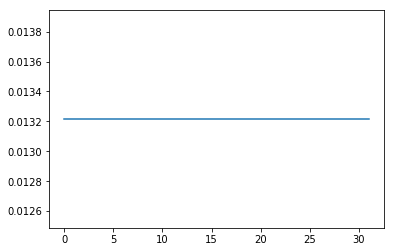

In [47]:
plt.plot(gsResults['Birch']['mean_train_score'])

In [49]:
gsResults['KMeans']['mean_train_score']

C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([ 0.02207169,  0.01625852,  0.02267353,  0.03804115,  0.03749225,
        0.03084151,  0.02411443,  0.03024105,  0.02903527,  0.03927864,
        0.02365698,  0.05545725,  0.01161494,  0.01890038,  0.02881946,
        0.02990516,  0.02541412,  0.02803381,  0.02601022,  0.02895328,
        0.01530675,  0.02703363,  0.01792473,  0.02333012])

In [51]:
from sklearn.model_selection import StratifiedKFold

In [58]:
X = inputData.trainingData[:100]
y = inputData.trainingLabels[:100]

In [61]:
k = StratifiedKFold(n_splits=5)

In [62]:
list(k.split(X,y))

[(array([16, 17, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38,
         39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
         56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18,
         19, 22, 23, 32, 33])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18,
         19, 22, 23, 29, 31, 32, 33, 35, 37, 38, 42, 45, 46, 47, 48, 49, 51,
         52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
         71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
         88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
  array([16, 17, 20, 21, 24, 25, 26, 27, 28, 30, 34, 36, 39, 40, 41, 43, 44,
         50, 55, 56])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,